# k-means with text data

In [60]:
import graphlab
import numpy as np
import pandas as pd
from __future__ import division
import matplotlib.pyplot as plt
import os

## Load data, extract features

In [61]:
wiki = graphlab.SFrame("E:\\Machine Learning\\U.W\\Cluster and Retrieval\\people_wiki.gl/")
wiki.save("E:\\Machine Learning\\U.W\\Cluster and Retrieval\\people_wiki.csv", format="csv")
wiki = pd.read_csv("E:\\Machine Learning\\U.W\\Cluster and Retrieval\\people_wiki.csv")

In [62]:
wiki.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [106]:
tfidf = TfidfVectorizer()
corpus = tfidf.fit_transform(wiki["text"])[:, :547979]
mapping = tfidf.get_feature_names()[:547979]

In [107]:
corpus[0, :].toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [110]:
mapping_table = pd.DataFrame({"feature": ["feature"]*len(mapping), "category": mapping})
mapping_table["index"] = mapping_table.index
mapping_table = mapping_table[["feature", "category", "index"]]

In [111]:
mapping_table

,feature,category,index
0,feature,00,0
1,feature,000,1
2,feature,0000,2
3,feature,00000,3
4,feature,00000van,4
5,feature,0001,5
6,feature,00014338,6
7,feature,0001sec,7
8,feature,0002,8
9,feature,00026,9


The above matrix contains a TF-IDF score for each of the 59071 pages in the data set and each of the 548429 unique words.

## Normalize all vectors

As discussed in the previous assignment, Euclidean distance can be a poor metric of similarity between documents, as it unfairly penalizes long articles. For a reasonable assessment of similarity, we should disregard the length information and use length-agnostic metrics, such as cosine distance.

The k-means algorithm does not directly work with cosine distance, so we take an alternative route to remove length information: we normalize all vectors to be unit length. It turns out that Euclidean distance closely mimics cosine distance when all vectors are unit length. In particular, the squared Euclidean distance between any two vectors of length one is directly proportional to their cosine distance.

In [112]:
from sklearn.preprocessing import normalize

In [113]:
tf_idf = normalize(corpus)

In [114]:
tf_idf

<59071x547979 sparse matrix of type '<type 'numpy.float64'>'
	with 10242872 stored elements in Compressed Sparse Row format>

## Implement k-means

Let us implement the k-means algorithm. First, we choose an initial set of centroids. A common practice is to choose randomly from the data points.

In [115]:
def get_initial_centroids(data, k, seed=None):
    if seed is not None:
        np.random.seed(seed)
        
    n = data.shape[0]
    
    # Pick k indices from range [0, N]
    rand_indices = np.random.randint(0, n, k)
    
    centroids = data[rand_indices, :].toarray()
    
    
    return centroids

In [116]:
get_initial_centroids(tf_idf, k=3, seed=0)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

After initialization, the k-means algorithm iterates between the following two steps:
1. Assign each data point to the closest centroid.
$$
z_i \gets \mathrm{argmin}_j \|\mu_j - \mathbf{x}_i\|^2
$$
2. Revise centroids as the mean of the assigned data points.
$$
\mu_j \gets \frac{1}{n_j}\sum_{i:z_i=j} \mathbf{x}_i
$$

### Assigning clusters

In [117]:
from sklearn.metrics import pairwise_distances

# Get the TF-IDF vectors for documents 100 through 102.
queries = tf_idf[100:102, :]

# Compute pairwise distances from every data point to each query vector.
dist = pairwise_distances(tf_idf, queries, metric = "euclidean")

print dist

[[1.34969092 1.29516812]
 [1.38493918 1.39057177]
 [1.35282917 1.36704157]
 ...
 [1.3767731  1.35330366]
 [1.36099317 1.25110334]
 [1.34549925 1.36682984]]


**Checkpoint:**

In [118]:
initial_centroids = tf_idf[:3, :]
dist_all = pairwise_distances(tf_idf, initial_centroids, metric="euclidean")
dist = pairwise_distances(tf_idf[430, :], initial_centroids[1])

In [119]:
'''Test cell'''
if np.allclose(dist, pairwise_distances(tf_idf[430,:], tf_idf[1,:])):
    print('Pass')
else:
    print('Check your code again')

Pass


**Checkpoint:** 

In [120]:
distances = pairwise_distances(tf_idf, initial_centroids, metric="euclidean")
closest_cluster = np.argmin(distances, axis=1)

In [121]:
'''Test cell'''
reference = [list(row).index(min(row)) for row in distances]
if np.allclose(closest_cluster, reference):
    print('Pass')
else:
    print('Check your code again')

Pass


In [122]:
initial_centroids = tf_idf[:3, :]
distances = pairwise_distances(tf_idf, initial_centroids, metric="euclidean")
cluster_assignment = np.argmin(distances, axis=1)

In [123]:
cluster_assignment

array([0, 1, 2, ..., 0, 0, 0], dtype=int64)

In [124]:
def assign_clusters(data, centroids):
    distances_from_centroids = pairwise_distances(data, centroids, metric="euclidean")
    cluster_assignment = np.argmin(distances_from_centroids, axis=1)
    
    return cluster_assignment

### Revising clusters

Let's turn to Step 2, where we compute the new centroids given the cluster assignments.

To develop intuition about filtering, let's look at a toy example consisting of 3 data points and 2 clusters.

In [125]:
data = np.array([[1., 2., 0.],
                 [0., 0., 0.],
                 [2., 2., 0.]])

centroids = np.array([[0.5, 0.5, 0.],
                      [0., -0.5, 0.]])

Let's assign these data points to the closest centroid.

In [126]:
cluster_assignment = assign_clusters(data, centroids)

print cluster_assignment

[0 1 0]


In [127]:
cluster_assignment == 1

array([False,  True, False])

In [128]:
cluster_assignment == 0

array([ True, False,  True])

First, let's look at the data points (i.e., their values) assigned to cluster 1:

In [129]:
data[cluster_assignment == 1]

array([[0., 0., 0.]])

Now let's look at the data points assigned to cluster 0:

In [130]:
data[cluster_assignment == 0]

array([[1., 2., 0.],
       [2., 2., 0.]])

Given all the data points in a cluster, it only remains to compute the mean.

In [131]:
data[cluster_assignment==0].mean(axis=0)

array([1.5, 2. , 0. ])

We are now ready to complete this function:

In [132]:
def revise_centroids(data, k, cluster_assignment):
    new_centroids = []
    
    for i in xrange(k):
        member_data_points = data[cluster_assignment == i]
        centroids = member_data_points.mean(axis=0)
        centroids = centroids.A1
        new_centroids.append(centroids)
        
    new_centroids = np.array(new_centroids)
    
    
    return new_centroids

### Assessing convergence

How can we tell if the k-means algorithm is converging? We can look at the cluster assignments and see if they stabilize over time. In fact, we'll be running the algorithm until the cluster assignments stop changing at all. To be extra safe, and to assess the clustering performance, we'll be looking at an additional criteria: the sum of all squared distances between data points and centroids. This is defined as
$$
J(\mathcal{Z},\mu) = \sum_{j=1}^k \sum_{i:z_i = j} \|\mathbf{x}_i - \mu_j\|^2.
$$
The smaller the distances, the more homogeneous the clusters are. In other words, we'd like to have "tight" clusters.

In [133]:
def compute_heterogeneity(data, k, centroids, cluster_assignment):
    heterogeneity = 0.0
    
    for i in xrange(k):
        member_data_points = data[cluster_assignment==i, :]
        
        if member_data_points.shape[0] > 0:
            distances = pairwise_distances(member_data_points, [centroids[i]], metric="euclidean")
            squared_distances = distances**2
            heterogeneity += np.sum(squared_distances)
            
            
    return heterogeneity

In [134]:
compute_heterogeneity(data, 2, centroids, cluster_assignment)

7.25

### Combining into a single function

Once the two k-means steps have been implemented, as well as our heterogeneity metric we wish to monitor, it is only a matter of putting these functions together to write a k-means algorithm that

* Repeatedly performs Steps 1 and 2
* Tracks convergence metrics
* Stops if either no assignment changed or we reach a certain number of iterations.

In [135]:
def kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False):
    centroids = initial_centroids[:]
    prev_cluster_assignment = None
    
    for itr in xrange(maxiter):
        if verbose:
            print (itr)
            
        # 1. Make cluster assignments using nearest centroids.
        cluster_assignment = assign_clusters(data, centroids)
        
        # 2. Compute a new centroids for each of the k clusters, averaging all data points assigned to that cluster.
        centroids = revise_centroids(data, k, cluster_assignment)
        
        # Check for convergence: if none of the assignments changed, stop
        if prev_cluster_assignment is not None and (prev_cluster_assignment==cluster_assignment).all():
            break
            
        # Print number of new assignments
        if prev_cluster_assignment is not None:
            num_changed = np.sum(prev_cluster_assignment != cluster_assignment)
            if verbose:
                print ("     {0:5d} elements changed their cluster assignment.".format(num_changed))
                
        # Record heterogeneity convergence metric.
        if record_heterogeneity is not None:
            score = compute_heterogeneity(data, k, centroids, cluster_assignment)
            record_heterogeneity.append(score)
            
        prev_cluster_assignment = cluster_assignment[:]
        
        
    return centroids, cluster_assignment

## Plotting convergence metric

We can use the above function to plot the convergence metric across iterations.

In [136]:
def plot_heterogeneity(heterogeneity, k):
    plt.figure(figsize=(7, 4))
    plt.plot(heterogeneity, linewidth=4)
    plt.xlabel("# Iterations")
    plt.ylabel("Heterogeneity")
    plt.title("Heterogeneity of clustering over time, K={0:d}".format(k))
    plt.rcParams.update({"font.size": 16})
    plt.tight_layout()

Let's consider running k-means with K=3 clusters for a maximum of 400 iterations, recording cluster heterogeneity at every step. Then, let's plot the heterogeneity over iterations using the plotting function above.

0
1
      3232 elements changed their cluster assignment.
2
      4018 elements changed their cluster assignment.
3
      4354 elements changed their cluster assignment.
4
      3066 elements changed their cluster assignment.
5
      2204 elements changed their cluster assignment.
6
      1548 elements changed their cluster assignment.
7
      1100 elements changed their cluster assignment.
8
       794 elements changed their cluster assignment.
9
       621 elements changed their cluster assignment.
10
       507 elements changed their cluster assignment.
11
       412 elements changed their cluster assignment.
12
       368 elements changed their cluster assignment.
13
       284 elements changed their cluster assignment.
14
       214 elements changed their cluster assignment.
15
       197 elements changed their cluster assignment.
16
       161 elements changed their cluster assignment.
17
       109 elements changed their cluster assignment.
18
        74 elements changed their c

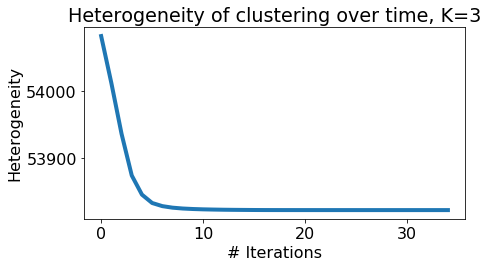

In [137]:
k = 3
heterogeneity = []
initial_centroids = get_initial_centroids(tf_idf, k, seed=0)
centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400, record_heterogeneity=heterogeneity, verbose=True)

plot_heterogeneity(heterogeneity, k)

**Q: Which of the cluster contains the greatest number of data points in the end?**

In [138]:
np.argmax(np.bincount(cluster_assignment))

0

## Beware of local maxima

One weakness of k-means is that it tends to get stuck in a local minimum. To see this, let us run k-means multiple times, with different initial centroids created using different random seeds.

In [139]:
import sys

In [140]:
k = 10
heterogeneity = {}

import time
start = time.time()

for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = get_initial_centroids(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400, record_heterogeneity=None, verbose=False)
    heterogeneity[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    
    print ("seed={0:06d}, heterogeneity={1: .5f}".format(seed, heterogeneity[seed]))
    sys.stdout.flush()
    
end = time.time()

print (end-start)

seed=000000, heterogeneity= 52856.17602
seed=020000, heterogeneity= 52830.78671
seed=040000, heterogeneity= 52955.14520
seed=060000, heterogeneity= 52796.48198
seed=080000, heterogeneity= 52743.53064
seed=100000, heterogeneity= 52839.67537
seed=120000, heterogeneity= 52861.52845
726.161000013


Notice the variation in heterogeneity for different initializations. This indicates that k-means sometimes gets stuck at a bad local minimum.

**Q: Another way to capture the effect of changing initialization is to look at the distribution of cluster assignments. Add a line to the code above to compute the size (# of member data points) of clusters for each run of k-means. Look at the size of the largest cluster (most # of member data points) across multiple runs, with seeds 0, 20000, ..., 120000. How much does this measure vary across the runs? What is the minimum and maximum values this quantity takes?**

In [141]:
k = 10
heterogeneity = {}

import time
start = time.time()
max_cluster_assignment = []

for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = get_initial_centroids(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400, record_heterogeneity=None, verbose=False)
    heterogeneity[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    max_cluster_assignment.append(np.max(np.bincount(cluster_assignment)))
    
    print ("seed={0:06d}, heterogeneity={1:.5f}".format(seed, heterogeneity[seed]))
    sys.stdout.flush()
     
end = time.time()
print (end-start)

print np.min(max_cluster_assignment)

seed=000000, heterogeneity=52856.17602
seed=020000, heterogeneity=52830.78671
seed=040000, heterogeneity=52955.14520
seed=060000, heterogeneity=52796.48198
seed=080000, heterogeneity=52743.53064
seed=100000, heterogeneity=52839.67537
seed=120000, heterogeneity=52861.52845
755.750999928
13337


One effective way to counter this tendency is to use **k-means++** to provide a smart initialization. This method tries to spread out the initial set of centroids so that they are not too close together. It is known to improve the quality of local optima and lower average runtime.

In [142]:
def smart_initialize(data, k, seed=None):
    if seed is not None:
        np.random.seed(seed)
        
    centroids = np.zeros((k, data.shape[1]))
    
    # Randomly choose the first centroid.
    idx = np.random.randint(data.shape[0])
    centroids[0] = data[idx, :].toarray()
    
    # Compute distances from the first centroid chosen to all the other data points.
    squared_distances = pairwise_distances(data, centroids[0:1], metric="euclidean").flatten()**2
    
    for i in xrange(1, k):
        # Choose the next centroid randomly, so that the probability for each data point to be chosen
        # is directly proportional to its squared distance from the nearest centroid.
        # Roughly speaking, a new centroid should be as far as from other centroids as possible.
        idx = np.random.choice(data.shape[0], 1, p=squared_distances/sum(squared_distances))
        centroids[i] = data[idx, :].toarray()
        squared_distances = np.min(pairwise_distances(data, centroids[0:i+1], metric="euclidean")**2, axis=1)
        
        
    return centroids

Let's now rerun k-means with 10 clusters using the same set of seeds, but always using k-means++ to initialize the algorithm.

In [143]:
k = 10
heterogeneity_smart = {}
start = time.time()

for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = smart_initialize(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400, record_heterogeneity=None, verbose=False)
    heterogeneity_smart[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    
    print ("seed={0:06d}, heterogeneity={1:.5f}".format(seed, heterogeneity_smart[seed]))
    sys.stdout.flush()
    
end = time.time()

print (end - start)

seed=000000, heterogeneity=52862.60543
seed=020000, heterogeneity=52777.62524
seed=040000, heterogeneity=52752.93124
seed=060000, heterogeneity=52792.69967
seed=080000, heterogeneity=52798.09667
seed=100000, heterogeneity=52789.22246
seed=120000, heterogeneity=52834.20748
492.368000031


Let's compare the set of cluster heterogeneities we got from our 7 restarts of k-means using random initialization compared to the 7 restarts of k-means using k-means++ as a smart initialization.

The following code produces a box plot for each of these methods, indicating the spread of values produced by each method.

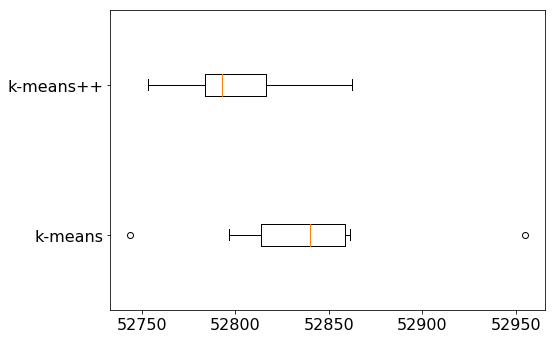

In [144]:
plt.figure(figsize=(8, 5))

plt.boxplot([heterogeneity.values(), heterogeneity_smart.values()], vert=False)
plt.yticks([1, 2], ["k-means", "k-means++"])
plt.rcParams.update({"font.size": 16})

plt.tight_layout()

**In general, you should run k-means at least a few times with different initializations and then return the run resulting in the lowest heterogeneity.** Let us write a function that runs k-means multiple times and picks the best run that minimizes heterogeneity. The function accepts an optional list of seed values to be used for the multiple runs; if no such list is provided, the current UTC time is used as seed values.

In [145]:
def kmeans_multiple_runs(data, k, maxiter, num_runs, seed_list=None, verbose=False):
    heterogeneity = {}
    
    min_heterogeneity_achieved = float("inf")
    best_seed = None
    final_centroids = None
    final_cluster_assignment = None
    
    for i in xrange(num_runs):
        # Use UTC time if no seeds are provided.
        if seed_list is not None:
            seed = seed_list[i]
            np.random.seed(seed)
        else:
            seed = int(time.time())
            np.random.seed(seed)
            
        # Use k-means++ initialization
        initial_centroids = smart_initialize(data, k, seed=seed)
        
        # Run k-means
        centroids, cluster_assignment = kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False)
        heterogeneity[seed] = compute_heterogeneity(data, k, centroids, cluster_assignment)
        
        if verbose:
            print ("seed={0:06d}, heterogeneity={1:.5f}".format(seed, heterogeneity[seed]))
            
        # if current measurement of heterogeneity is lower than previously seen,
        # update the minimum record of heterogeneity.
        if heterogeneity[seed] < min_heterogeneity_achieved:
            min_heterogeneity_achieved = heterogeneity[seed]
            best_seed = seed
            final_centroids = centroids
            final_cluster_assignment = cluster_assignment
            
            
    return final_centroids, final_cluster_assignment

## How to choose K

Since we are measuring the tightness of the clusters, a higher value of K reduces the possible heterogeneity metric by definition. Let's explore this general trend for ourselves by performing the following analysis. 

2
10
25
50
100


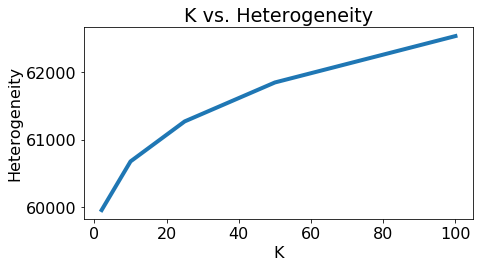

In [148]:
def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
    plt.figure(figsize=(7, 4))
    plt.plot(k_values, heterogeneity_values, linewidth=4)
    plt.xlabel("K")
    plt.ylabel("Heterogeneity")
    plt.title("K vs. Heterogeneity")
    plt.rcParams.update({"font.size": 16})
    plt.tight_layout()

filename = "E:\\Machine Learning\\U.W\\Cluster and Retrieval\\kmeans-arrays.npz"

heterogeneity_values = []
k_list = [2, 10, 25, 50, 100]

if os.path.exists(filename):
    arrays = np.load(filename)
    centroids = {}
    cluster_assignment = {}
    for k in k_list:
        print k
        sys.stdout.flush()
        centroids[k] = lambda k=k: arrays["centroids_{0:d}".format(k)]
        cluster_assignment[k] = lambda k=k: arrays["cluster_assignment_{0:d}".format(k)]
        score = compute_heterogeneity(tf_idf, k, centroids[k](), cluster_assignment[k]())
        heterogeneity_values.append(score)
        
    plot_k_vs_heterogeneity(k_list, heterogeneity_values)

else:
    print("File not found. Skipping")

**Not right!!!!!!!!**